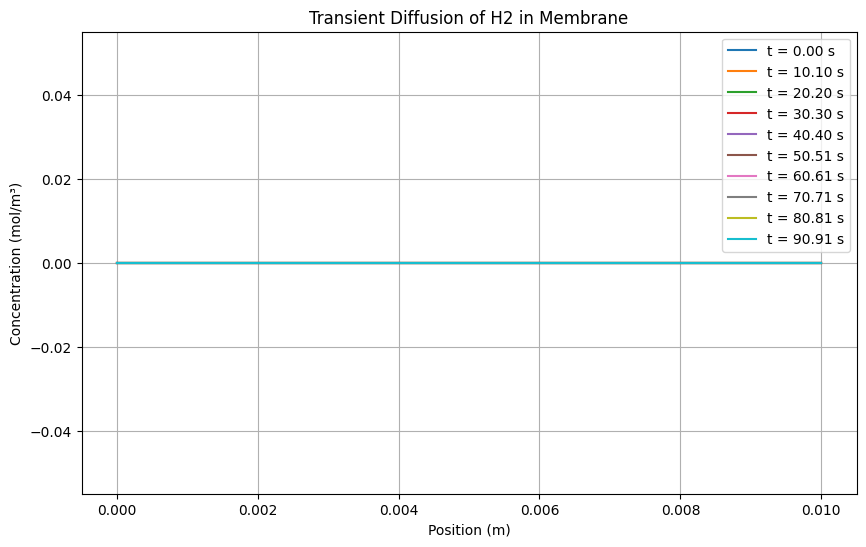

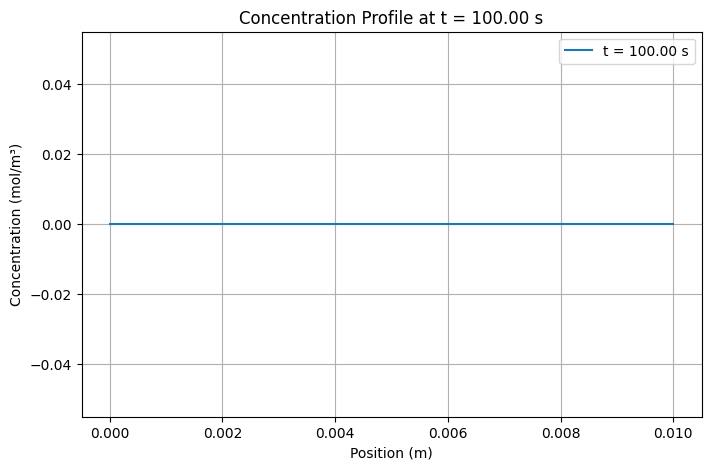

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# 1. Define parameters
L = 0.01  # Membrane thickness (m)
D = 1e-9  # Diffusion coefficient (m^2/s)
N = 21    # Number of spatial points
dx = L / (N - 1)
time_end = 100  # End time for the simulation (s)

# 2. Define the spatial grid
x = np.linspace(0, L, N)

# 3. Define the initial condition (concentration = 0 everywhere initially)
initial_concentration = np.zeros(N)

# 4. Define the boundary conditions (Dirichlet)
boundary_concentration_left = 1.0  # Concentration at x = 0
boundary_concentration_right = 0.0 # Concentration at x = L

# 5. Define the function that returns the time derivative of the concentration vector
def diffusion_equation(t, C):
    dCdt = np.zeros_like(C)

    # Apply boundary conditions
    dCdt[0] = 0  # Concentration at the boundary is fixed
    dCdt[-1] = 0 # Concentration at the boundary is fixed

    # Calculate the concentration at the internal points using Fick's Second Law (discretized)
    for i in range(1, N - 1):
        dCdt[i] = D * (C[i + 1] - 2 * C[i] + C[i - 1]) / dx**2

    return dCdt

# 6. Set up the time span for the simulation
t_span = (0, time_end)
t_eval = np.linspace(0, time_end, 100) # Evaluate the solution at these time points

# 7. Solve the ODE system
sol = solve_ivp(diffusion_equation, t_span, initial_concentration,
                method='RK45', t_eval=t_eval)

# 8. Extract the results
time = sol.t
concentration = sol.y

# 9. Visualize the results
plt.figure(figsize=(10, 6))
for i in range(0, len(time), 10):  # Plot every 10th time point
    plt.plot(x, concentration[:, i], label=f't = {time[i]:.2f} s')

plt.xlabel('Position (m)')
plt.ylabel('Concentration (mol/m³)')
plt.title('Transient Diffusion of H2 in Membrane')
plt.legend()
plt.grid(True)
plt.show()

# We can also plot the concentration profile at the final time
plt.figure(figsize=(8, 5))
plt.plot(x, concentration[:, -1], label=f't = {time[-1]:.2f} s')
plt.xlabel('Position (m)')
plt.ylabel('Concentration (mol/m³)')
plt.title(f'Concentration Profile at t = {time[-1]:.2f} s')
plt.legend()
plt.grid(True)
plt.show()

Starting ODE solver...
Solver finished.
ODE solver successful. Number of time steps evaluated: 101


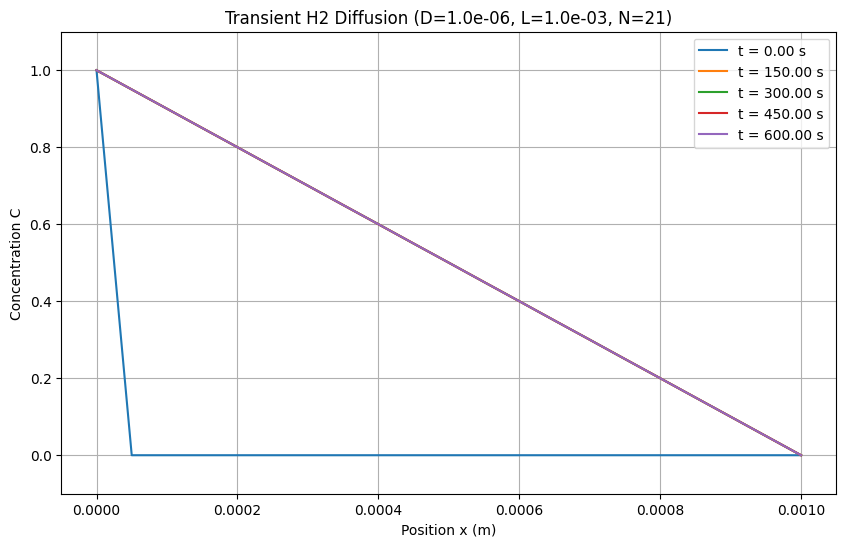

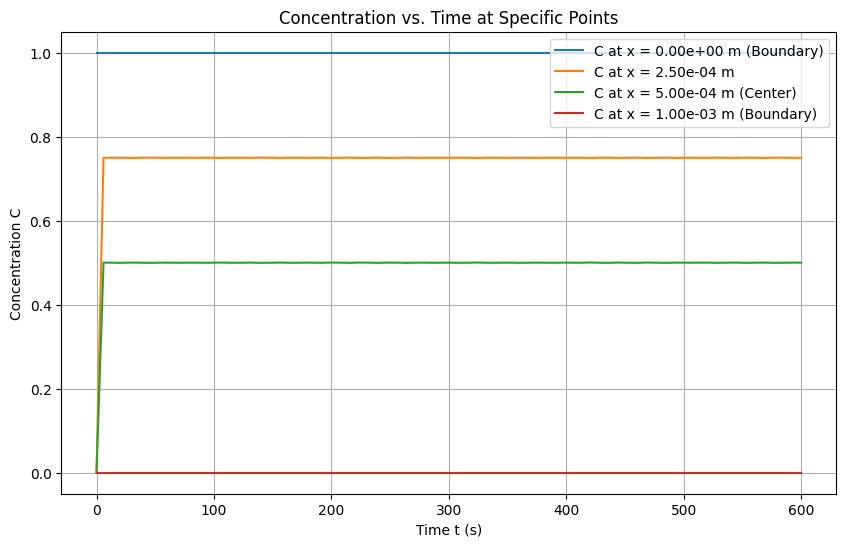

In [2]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# --- Part 1: Parameters & Discretization Setup ---
# Physical Parameters
D = 1e-6  # Diffusion coefficient (e.g., m^2/s) - Use a realistic value for H2 if known
L = 1e-3  # Membrane thickness (e.g., m)

# Simulation Parameters (Week 1 - Small Test Case)
N = 21     # Number of spatial grid points (including boundaries)
dx = L / (N - 1) # Spatial step size
x = np.linspace(0, L, N) # Spatial grid

# Time Parameters (Week 1 - Short duration)
t_start = 0.0
t_end = 60 * 10  # Simulate for 10 minutes initially (seconds)
t_span = (t_start, t_end)
t_eval = np.linspace(t_start, t_end, 101) # Evaluate at 101 time points

# Boundary Conditions (Dirichlet)
C_left = 1.0   # Concentration at x=0 (e.g., mol/m^3 or arbitrary units)
C_right = 0.0  # Concentration at x=L

# Initial Condition
C0 = np.zeros(N) # Start with zero concentration everywhere initially
C0[0] = C_left   # Set initial concentration at the left boundary
C0[-1] = C_right # Set initial concentration at the right boundary
# Note: For consistency, ensure the initial condition respects the boundary conditions.

# --- Part 2: ODE Function Implementation (Method of Lines) ---
def ficks_ode(t, C, D, dx, N, C_left, C_right):
    """
    Calculates the time derivative of concentration dC/dt for Fick's Second Law
    using the Method of Lines with Finite Differences.

    Args:
        t (float): Current time (required by solve_ivp, may not be used directly here).
        C (np.ndarray): Current concentration profile vector (size N).
        D (float): Diffusion coefficient.
        dx (float): Spatial step size.
        N (int): Number of grid points.
        C_left (float): Fixed concentration at the left boundary (x=0).
        C_right (float): Fixed concentration at the right boundary (x=L).

    Returns:
        np.ndarray: Vector of time derivatives dC/dt (size N).
    """
    dCdt = np.zeros(N)

    # Apply Finite Difference for interior nodes (i=1 to N-2)
    for i in range(1, N - 1):
        dCdt[i] = D * (C[i+1] - 2*C[i] + C[i-1]) / dx**2

    # Apply Boundary Conditions (Dirichlet: Concentration is fixed)
    # The concentrations C[0] and C[N-1] are *inputs* determined by the solver's
    # state vector. To keep them fixed, their time derivatives *must* be zero.
    dCdt[0] = 0.0
    dCdt[N-1] = 0.0

    return dCdt

# --- Part 3: ODE Solver Integration ---
print("Starting ODE solver...")
# Use solve_ivp to integrate the ODE system
# Methods to consider:
# 'RK45': Default, good for non-stiff problems.
# 'BDF': Good for stiff problems (may arise with fine grids/long times).
# 'Radau': Another option for stiff problems.
sol = solve_ivp(
    fun=ficks_ode,
    t_span=t_span,
    y0=C0,
    method='RK45', #'BDF' could be used if stiffness is suspected
    t_eval=t_eval,
    args=(D, dx, N, C_left, C_right) # Pass additional arguments to ficks_ode
)
print("Solver finished.")

# Check if solver was successful
if not sol.success:
    print(f"ODE solver failed: {sol.message}")
else:
    print(f"ODE solver successful. Number of time steps evaluated: {len(sol.t)}")

    # --- Part 4: Visualization & Verification ---
    C_results = sol.y # Concentration profiles (shape N x num_t_eval)

    plt.figure(figsize=(10, 6))

    # Plot concentration profiles at different times
    num_plots = 5 # Number of profiles to show
    plot_indices = np.linspace(0, len(sol.t) - 1, num_plots, dtype=int)

    for i, t_idx in enumerate(plot_indices):
        time = sol.t[t_idx]
        plt.plot(x, C_results[:, t_idx], label=f't = {time:.2f} s')

    # Plot the steady-state analytical solution for comparison (linear profile for 1D Dirichlet)
    # C_steady = C_left + (C_right - C_left) * (x / L)
    # plt.plot(x, C_steady, 'k--', label='Steady State (Analytical)')

    plt.xlabel('Position x (m)')
    plt.ylabel('Concentration C')
    plt.title(f'Transient H2 Diffusion (D={D:.1e}, L={L:.1e}, N={N})')
    plt.legend()
    plt.grid(True)
    plt.ylim(min(C_right, C_left) - 0.1*(C_left-C_right+1e-9), max(C_right, C_left) + 0.1*(C_left-C_right+1e-9)) # Adjust ylim
    plt.show()

    # Optional: Plot concentration at specific points over time
    plt.figure(figsize=(10, 6))
    mid_point_index = N // 2
    quarter_point_index = N // 4
    plt.plot(sol.t, C_results[0, :], label=f'C at x = {x[0]:.2e} m (Boundary)')
    plt.plot(sol.t, C_results[quarter_point_index, :], label=f'C at x = {x[quarter_point_index]:.2e} m')
    plt.plot(sol.t, C_results[mid_point_index, :], label=f'C at x = {x[mid_point_index]:.2e} m (Center)')
    plt.plot(sol.t, C_results[-1, :], label=f'C at x = {x[-1]:.2e} m (Boundary)')

    plt.xlabel('Time t (s)')
    plt.ylabel('Concentration C')
    plt.title('Concentration vs. Time at Specific Points')
    plt.legend()
    plt.grid(True)
    plt.show()

In [3]:

# Consider using sparse matrices for larger problems, though not essential for N=21
# from scipy.sparse import lil_matrix, csc_matrix
# from scipy.sparse.linalg import spsolve

# --- Parameters (same as FDM example for comparison) ---
# Physical Parameters
D = 1e-6  # Diffusion coefficient (m^2/s)
L = 1e-3  # Membrane thickness (m)

# Simulation Parameters (FEM Mesh)
N_nodes = 21 # Number of nodes
N_elements = N_nodes - 1 # Number of linear elements
nodes = np.linspace(0, L, N_nodes) # Node coordinates
h = nodes[1] - nodes[0] # Element length (uniform mesh)

# Time Parameters
t_start = 0.0
# t_end = 60 * 10 # Simulate for 10 minutes (seconds) - same as FDM test
t_end = 60 * 60 * 2 # Simulate for 2 hours to see more evolution
t_span = (t_start, t_end)
t_eval = np.linspace(t_start, t_end, 151) # Evaluate at 151 time points

# Boundary Conditions (Dirichlet)
C_left = 1.0   # Concentration at x=0 (node 0)
C_right = 0.0  # Concentration at x=L (node N_nodes-1)
boundary_node_indices = [0, N_nodes - 1]
boundary_node_values = [C_left, C_right]

# Initial Condition
C0 = np.zeros(N_nodes) # Start with zero concentration
C0[boundary_node_indices[0]] = boundary_node_values[0] # Set BC in initial state
C0[boundary_node_indices[1]] = boundary_node_values[1] # Set BC in initial state

# --- FEM Matrix Assembly ---

# Initialize global matrices (using dense numpy arrays for simplicity here)
M_global = np.zeros((N_nodes, N_nodes))
K_global = np.zeros((N_nodes, N_nodes))

# Element matrices (linear elements)
m_elem = (h / 6.0) * np.array([[2, 1],
                                [1, 2]])
k_elem = (D / h) * np.array([[ 1, -1],
                                [-1,  1]])

# Assemble global matrices by iterating over elements
for i in range(N_elements):
    # Node indices for element 'i'
    node_idx1 = i
    node_idx2 = i + 1
    dof_indices = [node_idx1, node_idx2] # Degrees of freedom indices

    # Add element matrices to global matrices
    # Using np.ix_ for convenient indexing
    M_global[np.ix_(dof_indices, dof_indices)] += m_elem
    K_global[np.ix_(dof_indices, dof_indices)] += k_elem

# --- Define the ODE function for solve_ivp ---

def fem_ode(t, C, M, K, boundary_indices):
    """
    Calculates the time derivative dC/dt for the FEM system M*dC/dt = -K*C,
    enforcing Dirichlet boundary conditions.

    Args:
        t (float): Current time.
        C (np.ndarray): Current concentration vector (size N_nodes).
        M (np.ndarray): Global Mass Matrix.
        K (np.ndarray): Global Stiffness Matrix.
        boundary_indices (list): Indices of nodes with fixed Dirichlet BCs.

    Returns:
        np.ndarray: Vector of time derivatives dC/dt (size N_nodes).
    """
    # Calculate the right-hand side vector (-K*C)
    # Note: For time-dependent BCs or source terms, F vector would be added here
    rhs = -K @ C

    # Solve the linear system M * dCdt = rhs for dCdt
    # Using dense solver. For large N, use sparse matrix/solver
    try:
        dCdt = np.linalg.solve(M, rhs)
    except np.linalg.LinAlgError:
        print("Warning: Linear system solve failed. Using pseudo-inverse.")
        # Fallback, though M should be invertible if assembled correctly
        M_inv = np.linalg.pinv(M)
        dCdt = M_inv @ rhs


    # Enforce Dirichlet boundary conditions *after* solving
    # The concentration at these nodes should not change
    dCdt[boundary_indices] = 0.0

    return dCdt

# --- Solve the ODE System ---

print("Starting FEM ODE solver...")
sol_fem = solve_ivp(
    fun=fem_ode,
    t_span=t_span,
    y0=C0,
    method='RK45', # Try 'BDF' if simulation becomes stiff (longer times, finer mesh)
    t_eval=t_eval,
    args=(M_global, K_global, boundary_node_indices) # Pass FEM matrices and BC info
)
print("Solver finished.")

# Check success
if not sol_fem.success:
    print(f"FEM ODE solver failed: {sol_fem.message}")
else:
    print(f"FEM ODE solver successful. Number of time steps evaluated: {len(sol_fem.t)}")

    # --- Visualization ---
    C_results_fem = sol_fem.y # Concentration profiles (shape N_nodes x num_t_eval)

    plt.figure(figsize=(12, 7))

    # Plot concentration profiles at different times
    num_plots = 6 # Number of profiles to show
    plot_indices = np.linspace(0, len(sol_fem.t) - 1, num_plots, dtype=int)

    for i, t_idx in enumerate(plot_indices):
        time = sol_fem.t[t_idx]
        plt.plot(nodes, C_results_fem[:, t_idx], marker='o', linestyle='-', markersize=4, label=f't = {time/60:.1f} min') # Time in minutes

    # Plot steady-state analytical solution
    C_steady = C_left + (C_right - C_left) * (nodes / L)
    plt.plot(nodes, C_steady, 'k--', linewidth=1.5, label='Steady State (Analytical)')

    plt.xlabel('Position x (m)')
    plt.ylabel('Concentration C')
    plt.title(f'Transient H2 Diffusion (FEM, N={N_nodes}, D={D:.1e})')
    plt.legend()
    plt.grid(True)
    plt.ylim(min(C_right, C_left) - 0.1*(abs(C_left-C_right)+1e-9), max(C_right, C_left) + 0.1*(abs(C_left-C_right)+1e-9))
    plt.show()

    # Optional: Plot concentration at specific points over time
    plt.figure(figsize=(12, 7))
    mid_point_index = N_nodes // 2
    quarter_point_index = N_nodes // 4
    three_quarter_point_index = 3* (N_nodes // 4)

    plt.plot(sol_fem.t / 60, C_results_fem[0, :], label=f'C at x = {nodes[0]:.2e} m (BC)')
    plt.plot(sol_fem.t / 60, C_results_fem[quarter_point_index, :], label=f'C at x = {nodes[quarter_point_index]:.2e} m')
    plt.plot(sol_fem.t / 60, C_results_fem[mid_point_index, :], label=f'C at x = {nodes[mid_point_index]:.2e} m')
    plt.plot(sol_fem.t / 60, C_results_fem[three_quarter_point_index, :], label=f'C at x = {nodes[three_quarter_point_index]:.2e} m')
    plt.plot(sol_fem.t / 60, C_results_fem[-1, :], label=f'C at x = {nodes[-1]:.2e} m (BC)')

    plt.xlabel('Time t (min)')
    plt.ylabel('Concentration C')
    plt.title('Concentration vs. Time at Specific Points (FEM)')
    plt.legend()
    plt.grid(True)
    plt.show()

Starting FEM ODE solver...


KeyboardInterrupt: 

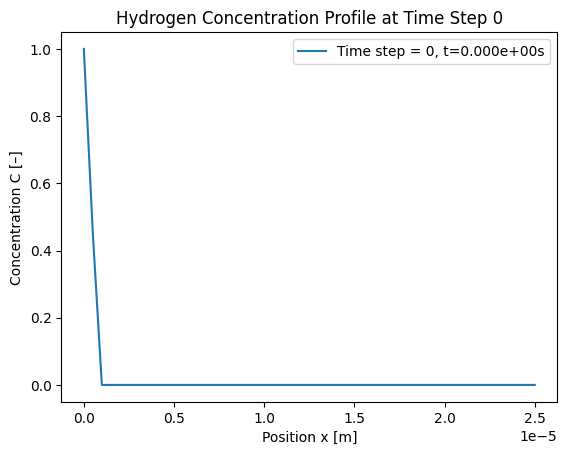

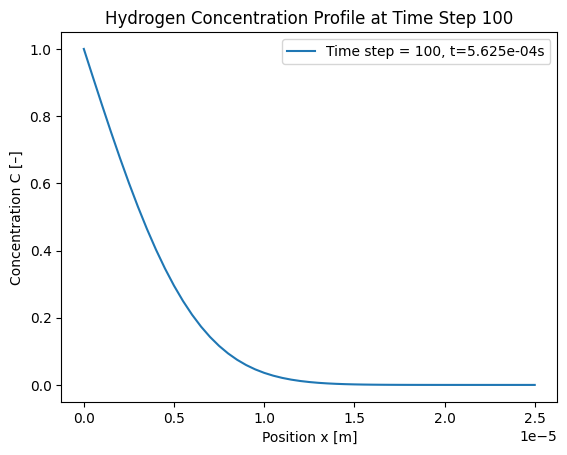

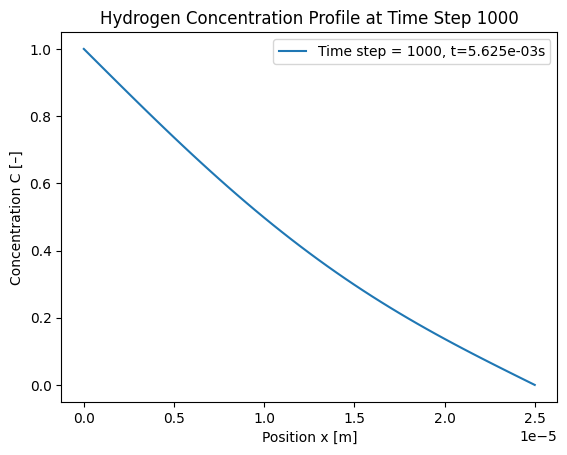

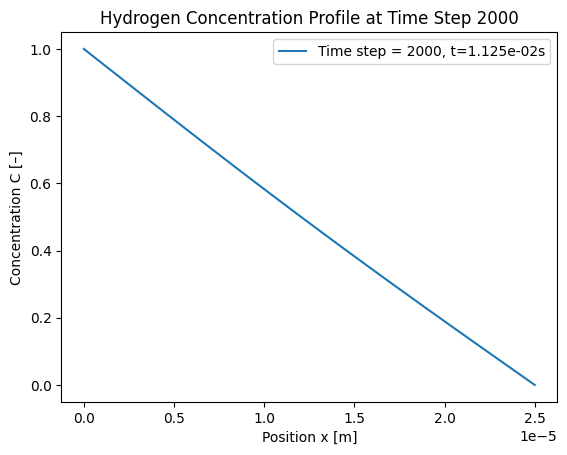

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1) Define physical parameters ---
L = 25e-6             # Length of membrane [m] (example)
D = 2e-8            # Diffusivity [m^2/s], typical order for hydrogen in some metals

# --- 2) Define numerical parameters ---
Nx = 51             # Number of spatial points
dx = L / (Nx - 1)   # Spatial step

# Stability criterion for explicit scheme:
# dt <= dx^2 / (2*D)
dt = 0.9 * dx**2 / (2*D)  # some safety factor 0.9
num_steps = 5000          # number of time steps to simulate

# --- 3) Create the spatial grid ---
x = np.linspace(0, L, Nx)

# --- 4) Initialize the concentration array ---
C = np.zeros(Nx)  # initial condition C(x,0)=0

# --- 5) Apply boundary conditions for t >= 0 ---
C_left = 1.0      # concentration at x=0
C_right = 0.0     # concentration at x=L
C[0] = C_left
C[-1] = C_right

# --- 6) Time-marching loop ---
C_history = []  # Keep track of some snapshots in time
time_points = [0, 100, 1000, 2000, 5000]  # times steps we want to keep

for n in range(num_steps):
    # Copy old concentration (to not overwrite while calculating)
    C_old = C.copy()
    
    # Update interior points (i=1 to Nx-2) using the explicit scheme
    for i in range(1, Nx-1):
        C[i] = C_old[i] + (D * dt / dx**2) * (C_old[i+1] - 2*C_old[i] + C_old[i-1])
    
    # Re-apply boundary conditions
    C[0] = C_left
    C[-1] = C_right
    
    # Store snapshots if needed
    if n in time_points:
        C_history.append((n, C.copy()))

# --- 7) Plot the results at the selected time steps ---
for (n, C_snap) in C_history:
    plt.figure()
    plt.plot(x, C_snap, label=f"Time step = {n}, t={n*dt:.3e}s")
    plt.xlabel("Position x [m]")
    plt.ylabel("Concentration C [–]")
    plt.title(f"Hydrogen Concentration Profile at Time Step {n}")
    plt.legend()
    plt.show()

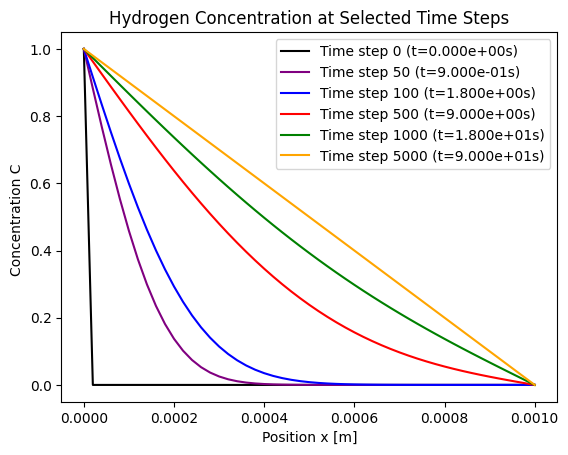

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1) Define physical parameters ---
L = 0.001      # membrane length [m]
D = 1e-8    # diffusivity [m^2/s]

# --- 2) Define numerical parameters ---
Nx = 51
dx = L / (Nx - 1)
dt = 0.9 * dx**2 / (2*D)  # explicit scheme stability criterion with a safety factor

num_steps = 5000
# dt = 3 * 24 *3/ num_steps
# --- 3) Create the spatial grid ---
x = np.linspace(0, L, Nx)

# --- 4) Initialize the concentration array for all time steps ---
#     We'll store concentration at every time step to facilitate plotting later.
C_time = np.zeros((num_steps + 1, Nx))

# --- 5) Set initial condition (t=0) and boundary conditions ---
C_time[0, :] = 0.0       # initial condition: concentration = 0 everywhere
C_left  = 1.0
C_right = 0.0
C_time[0, 0]  = C_left
C_time[0, -1] = C_right

# --- 6) Time-marching loop ---
for n in range(num_steps):
    # Copy the old time step:
    C_old = C_time[n].copy()
    C_new = C_old.copy()
    
    # Update interior points using the explicit scheme
    for i in range(1, Nx-1):
        C_new[i] = C_old[i] + (D * dt / dx**2) * (C_old[i+1] - 2*C_old[i] + C_old[i-1])
    
    # Reapply boundary conditions
    C_new[0]  = C_left
    C_new[-1] = C_right
    
    # Store the new concentration profile
    C_time[n+1, :] = C_new

# --- 7) Plot the concentration profiles for four different time steps on one figure ---
time_points = [0,50,100, 500, 1000, 5000]  # pick any four (or fewer) steps
colors = ["black","purple","blue", "red", "green", "orange"]  # each profile gets a unique color

plt.figure()
for i, t_step in enumerate(time_points):
    plt.plot(
        x,
        C_time[t_step, :],
        label=f"Time step {t_step} (t={t_step*dt:.3e}s)",
        color=colors[i]  # unique color for each line
    )

plt.xlabel("Position x [m]")
plt.ylabel("Concentration C ")
plt.title("Hydrogen Concentration at Selected Time Steps")
plt.legend()
plt.show()